## Создание VAE (+ исследование работы VAE (линейная реализация и на основе сверточных слоев) на различных входных данных и создание кастомного автоэнкодера), + использование сервиса wandb

#### Импортирование библиотек для дальнейшей работы

In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [106]:
import torch, torchvision
from torch import nn
import PIL
from torch.nn import functional as F
from torchvision import datasets, transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from torchsummary import summary
import seaborn as sns
from torchvision.utils import save_image
from torch.utils.data import Dataset
from random import randint
import random
import pandas as pd
from skimage import io

from IPython.display import Image, display 

import tqdm
import os
import logging
%matplotlib inline

In [74]:
import wandb


In [75]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: te200228. Use `wandb login --relogin` to force relogin


True

#### Проверяем, что видеокарта подключена успешно

In [8]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
print(device)

cuda:0


#### Посмотрим, как работает вариационный автоэнкодер: 
    Вариационные автоэнкодеры формируют параметры вектора длины n из случайных величин Xi, 
    причем i-е элементы векторов µ и σ являются средним и стандартным отклонением i-й случайной величины Xi. 
    Вместе эти величины образуют n-мерный случайный вектор, который посылается на декодер для восстановления данных

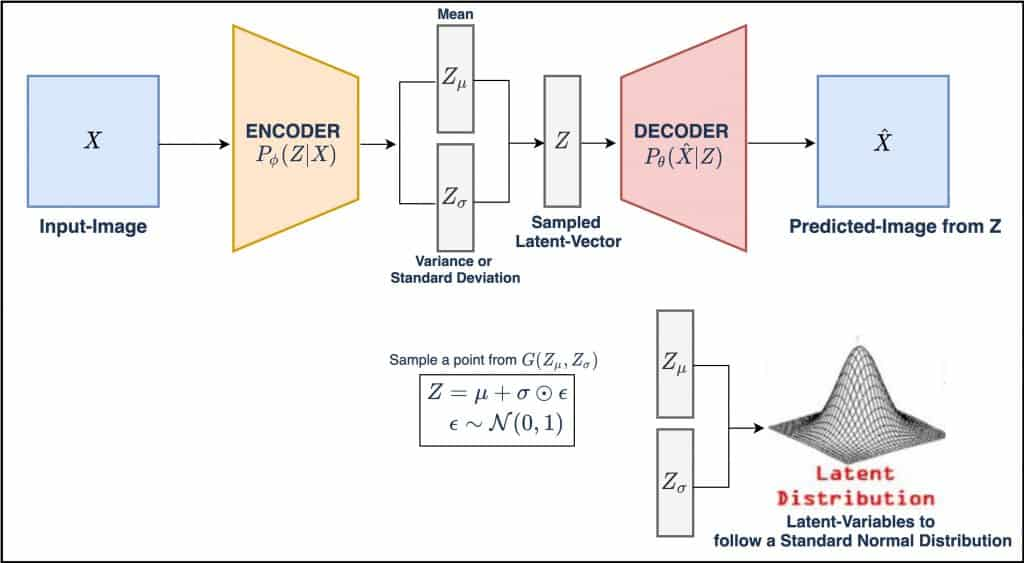

In [10]:
vae_explanation = Image(filename='vae.jpg')

display(vae_explanation)

In [235]:
mnist_transformations = torchvision.transforms.ToTensor()

#### Загружаем датасет и передаем его в лоадер

In [236]:
batch_size = 256
shuffle = True

In [237]:
data_test = datasets.MNIST(root='./data', train=False, download=True, transform= mnist_transformations)

In [238]:
data_train = datasets.MNIST(root='./data', train=True, download=True, transform= mnist_transformations)

In [239]:
test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size= batch_size, shuffle=True)

In [240]:
train_loader = torch.utils.data.DataLoader(dataset=data_train, batch_size= batch_size, shuffle=True)

#### Проверяем, что данные загружены корректно

In [241]:
fixed_x, _ = next(iter(train_loader))

In [242]:
fixed_x.size()

torch.Size([256, 1, 28, 28])

#### Наша модель будет работать следующим образом:
1) Input img -> Hidden dim -> mean, std -> Parametrization trick -> Decoder -> Output img
2) Hidden dim - делаем свертку для нашего изображения в пространство с меньшей размерностью и высчитываем вектор средних значений (mean) и вектор стандартных отклонений (std)
3) Parametrization trick - создаем функцию z из этих двух параметров, которая будет непрерывной, поэтому мы сможем по ней высчитывать back propaganation
4) Decoder - тут мы восстанавливаем картинку по z

In [249]:
class VAE(nn.Module):
    def __init__(self, input_dim: int, h_dim: int, z_dim: int):
        super().__init__()
        #encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)
        
        #decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)
        
        self.relu = nn.ReLU()
        
    def encoder(self, x: torch.tensor) -> tuple:
        hidden_dim = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(hidden_dim), self.hid_2sigma(hidden_dim)
        return mu, sigma
    
    def decoder (self, z: torch.tensor) -> torch.nn:
        hidden_dim = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(hidden_dim))
    
    def forward(self, x: torch.tensor) -> tuple:
        mu, sigma = self.encoder(x)
        epsilon = torch.rand_like(sigma)
        z_last = mu + sigma*epsilon
        x_recon = self.decoder(z_last)
        return x_recon, mu, sigma
        

#### Тут мы прогоняем нашу модель на рандомном датасете, чтобы убедиться, что слои выдают корректные размерности 

In [250]:
x = torch.randn(4, 28*28)
vae = VAE(input_dim = 784, h_dim = 16, z_dim = 4)
x_reconstructed, mu, sigma =  vae(x)
print(x_reconstructed.shape)
print(mu.shape)
print(sigma.shape)

torch.Size([4, 784])
torch.Size([4, 4])
torch.Size([4, 4])


In [251]:
input_dim = 784
image_channels = 1
h_dim = 200
z_dim = 20
num_epochs = 10

#### Теперь создаем объект класса VAE, задаем необходимые параметры, а также инициализируем  оптимайзер и задаем функцию потерь

In [252]:
model = VAE(input_dim, h_dim, z_dim).to(device)

In [253]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [254]:
loss_fn = nn.BCELoss(reduction = "sum")

#### Обучаем нашу модель и смотрим на функцию потерь, которая состоит из kl дивергенции и бинарной кросс энтропии. Логгирование осуществляется с помощью модуля tqdm

In [ ]:
for epoch in range(num_epochs):
    loop = tqdm.tqdm(enumerate(train_loader))
    for i, (img, _) in loop:
        
        img = img.to(device).view(img.shape[0], input_dim)
        img_reconstructed, mu, sigma = model(img)
        
        
        reconstruction_loss = loss_fn(img_reconstructed, img)
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        
        loss = reconstruction_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss = loss.item())

#### Перебрасываем модель на процессор, тестируем модель на каждой цифре, сохраняем картинки и выводим их для оценки

In [24]:
model = model.to("cpu")

In [25]:
def inference(digit: int, num_examples=1):

    images = []
    idx = 0
    for x, y in data_train:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break

    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encoder(images[d].view(1, 784))
        encodings_digit.append((mu, sigma))

    mu, sigma = encodings_digit[digit]
    for example in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        out = model.decoder(z)
        out = out.view(-1, 1, 28, 28)
        save_image(images[digit], f"real_{digit}.png")
        save_image(out, f"generated_{digit}_ex{example}.png")

for idx in range(10):
    inference(idx, num_examples=2)

In [31]:
display(Image('generated_3_ex1.png', width=100, unconfined=True))

In [32]:
display(Image('real_3.png', width=100, unconfined=True))

#### Можем увидеть, что автоэнкодер сгенерировал уникальную цифру 3 с некоторым искажением, так как модель является упрощенной, а количество эпох равняется 10

#### Создадим два класса, которые будут использоваться при модели со сверточными слоями, чтобы в конце энкодера выдавалась колбаска-вектор, которую мы используем для mean, std, а потом все снова представляем в виде матрицы  

In [257]:
class Flatten(nn.Module):
    def forward(self, input: torch.tensor) -> torch.tensor:
        return input.view(input.size(0), -1)

In [258]:
class UnFlatten(nn.Module):
    def forward(self, input : torch.tensor, size=64) -> torch.tensor:
        return input.view(input.size(0), size, 1, 1)

#### Смотрим на наши красивые цифры :)

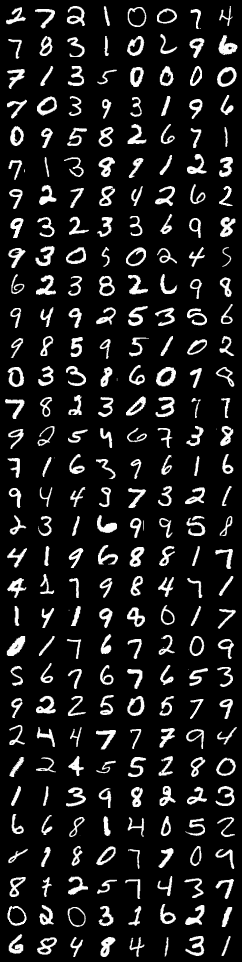

In [259]:

fixed_x, _ = next(iter(train_loader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

#### Тут у нас уже модель поитереснее: 
    энкодер состоит из трех сверточных слоев, каждый из которых кропает нашу картинку в два раза; декодер - восстанавливает изображение по скрытому слою; репараметризация - там мы вытаскиваем из декодера два вектора mean и std, и на их основе создаем функцию z, по которой уже будет считать градиенты и восстанавливать изображение, а также вспомогательные методы (save_model, load_model, forward)

In [260]:
 class VAE_CNN(nn.Module):

    def encoder_fn(self) -> torch.nn:
        encoder = nn.Sequential(
 
            nn.Conv2d(1, 16, 4, stride=2),
            nn.ReLU(), 
            nn.Conv2d(16, 32, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        return encoder

    def decoder_fn(self) -> torch.nn:
        
        decoder = nn.Sequential(
            
            UnFlatten(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2),
            nn.Sigmoid(),
        )
        return decoder

    def __init__(self, h_dim = 64, z_dim = 28):
        super().__init__()
        
        self.encoder = self.encoder_fn()
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.decoder = self.decoder_fn()
    
    def reparametrize(self, mu: torch.tensor, sigma:  torch.tensor) -> torch.tensor:
        std = torch.exp(0.5 * sigma)
        eps = torch.rand_like(std)
        z = mu + eps*std
        return z
     
    def bottleneck(self, h: torch.tensor) -> tuple:
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        z_reparametrized = self.reparametrize(mu, sigma)
        return z_reparametrized, mu, sigma
    
    def encode(self, x:  torch.tensor) -> tuple:
        h = self.encoder(x)
        z, mu, sigma = self.bottleneck(h)
        return z, mu, sigma

    def decode(self, z:  torch.tensor) -> torch.tensor:
        z = self.z_2hid(z)
        z = self.decoder(z)
        return z
    
    def save_model(self, model: torch.nn):
        torch.save(model.state_dict(), "model_weights.pth") # сохраняем веса нащей модели в файл "model_weights.pth"

    def load_model(self) -> torch.nn:
        # загружаем веса нащей модели в файл "model_weights.pth"
        model = TheModelClass(*args, **kwargs) 
        model.load_state_dict(torch.load("model_weights.pth"))
        return model

    def forward(self, x: torch.tensor) -> tuple:
        z, mu, sigma = self.encode(x)
        z = self.decode(z)
        return z, mu, sigma
    

#### Тут все по базе: 
    инициализируем модель, оптимайзер, создаем функцию потерь и прогоняем ее на 30 эпохах; логгирование процесса обучения уже производим с помощью wandb

In [261]:
model_cnn = VAE_CNN().to(device)

In [262]:
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=3e-4)
num_epochs = 30

In [263]:
def loss_func(recon_x: torch.tensor, x: torch.tensor, mu: torch.tensor, sigma: torch.tensor) -> tuple:
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.mean(1 + sigma - mu.pow(2) - sigma.exp())

    return BCE + KLD, BCE, KLD

In [247]:
# wandb.watch(model_cnn, log_freq=10)

In [ ]:
for epoch in range(num_epochs):
    loop = tqdm.tqdm(enumerate(train_loader))
    for i, (img, _) in loop:
        img = img.to(device)
        recon_images, mu, sigma = model_cnn(img)
        loss, bce, kld = loss_func(recon_images, img, mu, sigma)
        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()
        
        wandb.log({"Loss": loss, "bce": bce, "kld": kld})

In [302]:
wandb.init()

Loss,▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bce,████████████████████████▇▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁
kld,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,-252144992.0
bce,-252146080.0
kld,1088.11511


In [323]:
model_cnn = model_cnn.to("cpu")

In [265]:
def compare(x: torch.tensor) -> torch.tensor:
    recon_x, _, _ = model_cnn(x)
    return torch.cat([x, recon_x])

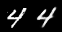

In [329]:
fixed_x = data_train[randint(1, 100)][0].unsqueeze(0)
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

#### Как мы можем увидеть, наша модель нарисовала даже более красивую с каллиграфической точки зрения цифру. Все работает корректно и без нареканий. Сверху можем увидеть, как наша функция потерь планомерно убывает, однако есть интересный скачок у kld, после которого он монотонно убывает. То есть можем сделать вывод, что сверточная сеть отработала эффективнее, так как является более совершеннной для данного типа задач. Все супер, движемся дальше: создадим кастомный датасет с методами:
1) init - загрузка данных и их инициализация: разбиение на картинки и лейблы, перевод в тензоры
2) len - возвращаем длину датасета
3) getitem - возвращаем требуемый элемент датасета, а также его метку
4) processing - тут мы нормализуем наши данные, чтобы значения пикселей были не от 0 до 255, а от 0 до 1
5) augmentation - делаем преобразования над входными данными и добавляем полученные изображения в датасет, чтобы увеличить выборку 

In [266]:
class CustomMNISTDataset():
    def __init__(self):
        self.df = pd.read_csv("mnist_train.csv")
        self.df_labels =  self.df[['label']]
        self.df = self.df.drop(columns = ['label'])
        
        self.dataset = torch.tensor(self.df.to_numpy()).reshape((-1,1,28,28)).float()
        self.labels = torch.tensor(self.df_labels.to_numpy()).reshape(-1).long()
    
    def __len__(self) -> int:
        return len(self.dataset)
    
    def __getitem__(self, idx: int) -> tuple:
        return self.dataset[idx], self.labels[idx]
    
    def processing(self):
        self.dataset = torch.div(self.dataset,torch.max(self.dataset))
    
    def augmentation(self) -> torch.tensor:
        return torch.cat([self.dataset, torch.tensor(np.rot90(self.df.to_numpy()).reshape((-1,1,28,28))).float()], 0)
    

Смотрим на наш датасет и проверяем, что все ок

In [267]:
ds = CustomMNISTDataset()
ds.processing()
len(ds)

60000

In [335]:
ds_loader = torch.utils.data.DataLoader(dataset=ds, batch_size=batch_size, shuffle=True)

In [336]:
fixed_x, _ = next(iter(ds_loader))
fixed_x.size()

torch.Size([256, 1, 28, 28])

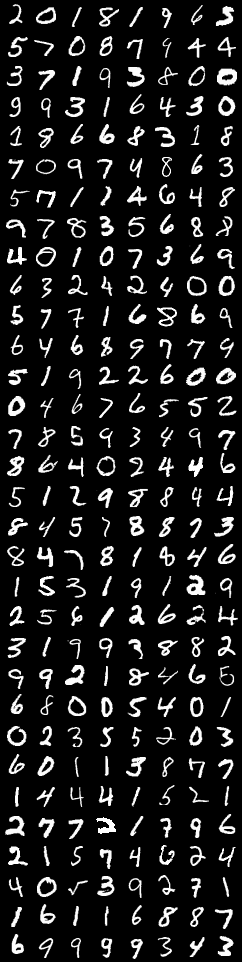

In [338]:
fixed_x, _ = next(iter(ds_loader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [339]:
counter = 0
for epoch in [1,2,3]:
    for batch, label in ds_loader:
        if counter == 0:
            print(batch, label)
            counter+=1
        print(batch.size(), label.size())

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([2

torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([2

torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([2

#### Как мы видим, данные загрузились корректно 

#### Обучаем теперь на кастомных данных и смотрим, что получилось

In [342]:
model_cnn2 = VAE_CNN().to(device)
optimizer_cnn2 = torch.optim.Adam(model_cnn2.parameters(), lr=3e-4)
num_epochs = 100

In [343]:
for epoch in range(num_epochs):
    loop = tqdm.tqdm(enumerate(ds_loader))
    for i, (img, _) in loop:
        img = img.to(device)
        recon_images, mu, sigma = model_cnn2(img)
        loss, bce, kld = loss_func(recon_images, img, mu, sigma)
        optimizer_cnn2.zero_grad()
        loss.backward()
        optimizer_cnn2.step()
        
        wandb.log({"Loss": loss, "bce": bce, "kld": kld})
        

0it [00:00, ?it/s]C:\Users\te200\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
235it [00:07, 30.70it/s]
235it [00:08, 28.94it/s]
235it [00:05, 41.54it/s]
235it [00:08, 27.76it/s]
235it [00:06, 37.02it/s]
235it [00:06, 35.54it/s]
235it [00:07, 32.16it/s]
235it [00:07, 31.96it/s]
235it [00:07, 29.71it/s]
235it [00:12, 19.53it/s]
235it [00:13, 17.85it/s]
235it [00:14, 16.16it/s]
235it [00:13, 16.82it/s]
235it [00:10, 22.89it/s]
235it [00:15, 15.41it/s]
235it [00:09, 24.75it/s]
235it [00:10, 22.62it/s]
235it [00:13, 16.99it/s]
235it [00:10, 23.24it/s]
235it [00:11, 20.06it/s]
235it [00:14, 15.77it/s]
235it [00:17, 13.25it/s]
235it [00:09, 25.13it/s]
235it [00:17, 13.06it/s]
235it [00:12, 18.55it/s]
235it [00:12, 18.50it/s]
235it [00:14, 16.45it/s]
235it [00:12, 18.88it/s]
235it [00:13, 17.87it/s]
235it [00:14, 16.35it/s]
235it [00:

In [341]:
wandb.init()

Loss,█▅▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bce,█▅▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kld,▁▇▇█▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Loss,6535.93066
bce,6506.98389
kld,28.94699


In [344]:
model_cnn2 = model_cnn2.to("cpu")

In [345]:
def compare2(x: torch.tensor) -> torch.tensor:
    recon_x, _, _ = model_cnn2(x)
    return torch.cat([x, recon_x])

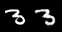

In [369]:
fixed_x = ds[randint(1, num_epochs)][0].unsqueeze(0).view(1,1,28,28)
compare_x2 = compare2(fixed_x)

save_image(compare_x2.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

#### Как мы можем заметить, модель также отлично показывает себя и на нашем кастомном датасете. Кроме того, можно заметить, что на одну эпоху уходит в 2-3 раза меньше времени, следовательно можно сделать вывод, что кастомный датасет позволяет увеличить скорость обучения засчет более быстрого обращения к ОЗУ. График функции потерь также не показывает каких либо выбросов, поэтому монжо сделать вывод, что модель работает корректно 

#### В этом задании я разобрался с VAE, научился создавать кастомный датасет, что мегаважно при работе с настоящими проектами, а также применил несколько вариаций VAE и попробовал wandb. Всем хорошего настроения, а я пошел спать 🌌

#### Создадим еще один кастомный датасет, но на этот раз будем работать с цветными изображениями покемонов. 
#### Первым делом нужно увеличить количество сэмплов, так как в датасете всего 809 покоменов, 
#### поэтому зададим пару трансформеров и произведем аугментацию датасета

In [280]:
# Здесь мы преобразуем наш numpy.narray в картинку, изменяем размер, переворачиваем, добавляем фильтры и преобразуем в тензор
transforms_version1 = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((28,28)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.ToTensor()
])

In [281]:
transforms_version2 = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((28,28)),
    torchvision.transforms.ColorJitter(hue=.07, saturation=.07),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.ToTensor()
])

In [175]:
batch_size = 32

#### Тут у нас считывается csv файл, в котором первая колонка - это названия картинок с форматом, а вторая - это метки классов. Считываем из данного файла поочередно названия, испаользуем их для нахождения путей до картинок, загружаем их в формате 'RGBA', передаем все в трансформер и преобразуем

In [269]:
class CustomDataset(Dataset):
  def __init__(self, csv_file : str, root_dir: str, transform = None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  def __len__(self) -> int:
    return len(self.annotations)
  
  def __getitem__(self,index: int) -> tuple:
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
        image = io.imread(img_path, pilmode='RGBA')
        y_label = torch.tensor(int(self.annotations.iloc[index,2]))
        
        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)
        

#### Загружаем данные, аугментируем их, передаем в лоадер и смотрим, что у нас получилось

In [270]:
dataset_pokemons_basic = CustomDataset(csv_file = 'pokemon.csv', root_dir = 'images', transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(28)
]))

In [282]:
def augmentation(times = 3):
    for time in range(times):
        tmp_1 = dataset_pokemons_transformed = CustomDataset(csv_file = 'pokemon.csv', root_dir = 'images', transform = transforms_version1)
        tmp_2 = dataset_pokemons_transformed = CustomDataset(csv_file = 'pokemon.csv', root_dir = 'images', transform = transforms_version2)
        if time == 0:
            tmp_total = torch.utils.data.ConcatDataset([tmp_1,tmp_2])
        else:
            tmp_total = torch.utils.data.ConcatDataset([tmp_total,tmp_1,tmp_2])
    return torch.utils.data.ConcatDataset([tmp_total, dataset_pokemons_basic])

In [283]:
dataset_pokemons_total = augmentation()

In [284]:
dataset_pokemons_total.__len__()

5656

In [285]:
for i in range(min(5, dataset_pokemons_total.__len__())):
    print(len(dataset_pokemons[i]))
    print(dataset_pokemons[i])

2
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0

C:\Users\te200\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [287]:
train_loader_pokemons = torch.utils.data.DataLoader(dataset = dataset_pokemons_total, batch_size = batch_size, shuffle = True)

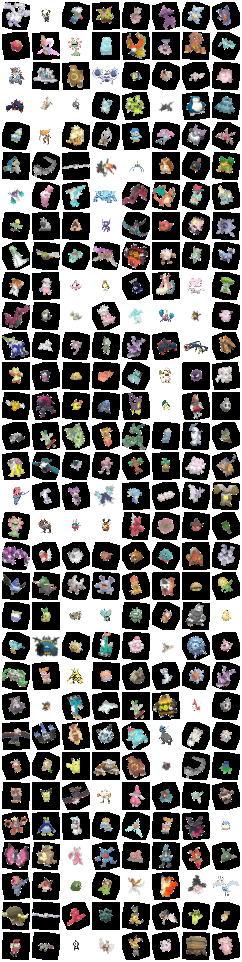

In [299]:
fixed_x, _ = next(iter(train_loader_pokemons))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [289]:
fixed_x.size()

torch.Size([4, 28, 28])

#### Как мы можем заметить, картинки загрузились корректно, с 4 каналами, характеризующими их цвет

In [301]:
class VAE_CNN_MULTICHANNELS(nn.Module):

    def encoder_fn(self) -> torch.nn:
        encoder = nn.Sequential(
 
            nn.Conv2d(4, 16, 4, stride=2),
            nn.ReLU(), 
            nn.Conv2d(16, 32, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        return encoder

    def decoder_fn(self) -> torch.nn:
        
        decoder = nn.Sequential(
            
            UnFlatten(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, kernel_size=4, stride=2),
            nn.Sigmoid(),
        )
        return decoder

    def __init__(self, h_dim = 64, z_dim = 28):
        super().__init__()
        
        self.encoder = self.encoder_fn()
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.decoder = self.decoder_fn()
    
    def reparametrize(self, mu: torch.tensor, sigma: torch.tensor) -> torch.tensor:
        std = torch.exp(0.5 * sigma)
        eps = torch.rand_like(std)
        z = mu + eps*std
        return z
     
    def bottleneck(self, h: torch.tensor) -> tuple:
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        z_reparametrized = self.reparametrize(mu, sigma)
        return z_reparametrized, mu, sigma
    
    def encode(self, x: torch.tensor) -> tuple:
        h = self.encoder(x)
        z, mu, sigma = self.bottleneck(h)
        return z, mu, sigma

    def decode(self, z: torch.tensor) -> torch.tensor:
        z = self.z_2hid(z)
        z = self.decoder(z)
        return z
    
    def save_model(self, model: torch.nn):
        torch.save(model.state_dict(), "model_weights.pth") # сохраняем веса нащей модели в файл "model_weights.pth"

    def load_model(self) -> torch.nn:
        # загружаем веса нащей модели в файл "model_weights.pth"
        model = TheModelClass(*args, **kwargs) 
        model.load_state_dict(torch.load("model_weights.pth"))
        return model

    def forward(self, x: torch.tensor) -> tuple:
        z, mu, sigma = self.encode(x)
        z = self.decode(z)
        return z, mu, sigma

In [305]:
model_cnn3 = VAE_CNN_MULTICHANNELS().to(device)
optimizer_cnn3 = torch.optim.Adam(model_cnn3.parameters(), lr=3e-4)
num_epochs = 120

In [303]:
wandb.init()

Loss,▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
bce,▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
kld,▁▄▅▄▆█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁
Loss,87931.76562
bce,87929.9375
kld,1.83164


#### Обучаем нашу модель и смотрим на результат

In [306]:
for epoch in range(num_epochs):
    loop = tqdm.tqdm(enumerate(train_loader_pokemons))
    for i, (img, _) in loop:
        img = img.to(device)
        recon_images, mu, sigma = model_cnn3(img)
        loss, bce, kld = loss_func(recon_images, img, mu, sigma)
        optimizer_cnn3.zero_grad()
        loss.backward()
        optimizer_cnn3.step()
        
        wandb.log({"Loss": loss, "bce": bce, "kld": kld})

23it [00:37,  1.63s/it]
23it [00:40,  1.78s/it]
23it [00:44,  1.92s/it]
23it [00:52,  2.26s/it]
23it [00:41,  1.82s/it]
23it [00:47,  2.05s/it]
23it [00:46,  2.01s/it]
23it [00:49,  2.13s/it]
23it [00:46,  2.01s/it]
23it [00:48,  2.12s/it]
23it [01:06,  2.89s/it]
23it [00:41,  1.83s/it]
23it [00:40,  1.75s/it]
23it [00:37,  1.64s/it]
23it [00:37,  1.62s/it]
23it [00:38,  1.70s/it]
23it [00:37,  1.61s/it]
23it [00:36,  1.59s/it]
23it [00:35,  1.56s/it]
23it [00:35,  1.55s/it]
23it [00:35,  1.56s/it]
23it [00:35,  1.54s/it]
23it [00:34,  1.52s/it]
23it [00:34,  1.52s/it]
23it [00:34,  1.49s/it]
23it [00:35,  1.52s/it]
23it [00:34,  1.48s/it]
23it [00:33,  1.48s/it]
23it [00:37,  1.61s/it]
23it [00:34,  1.50s/it]
23it [00:44,  1.95s/it]
23it [00:41,  1.82s/it]
23it [00:33,  1.47s/it]
23it [00:37,  1.64s/it]
23it [00:35,  1.54s/it]
23it [00:34,  1.48s/it]
23it [00:33,  1.46s/it]
23it [00:33,  1.47s/it]
23it [00:34,  1.49s/it]
23it [00:33,  1.46s/it]
23it [00:34,  1.52s/it]
23it [00:34,  1.

In [307]:
model_cnn3 = model_cnn3.to("cpu")

In [334]:
model_cnn3.save_model(model_cnn3)

In [335]:
def compare3(x: torch.tensor) -> torch.tensor:
    recon_x, _, _ = model_cnn3(x)
    return torch.cat([x, recon_x])

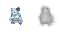

In [359]:
fixed_x = dataset_pokemons[randint(1, num_epochs)][0].unsqueeze(0).view(1,4,28,28)
compare_x3 = compare3(fixed_x)

save_image(compare_x3.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

#### Как можно заметить, автоэнкодеру удалось воспроизвести очертания покемона, однако сама детализация практически полностью отсутствует. Это связано с тем, что мы используем слишком маленькое разрешение для работы с таким типом картинок

#### Так как мой компьютер умер уже на разрешении 28x28, то предлагаю посмотреть, как мы можем улучшить результат за счет рескейлинга нашего изображений до 64x64: https://colab.research.google.com/drive/1mmTWS7Gjfp1V_PYFWW7Xy4uvncF2Ey7p?usp=sharing